<a href="https://colab.research.google.com/github/AlvaroBecker/predicciones-de-ventas/blob/parte3/predicciones_de_ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.2.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [47]:
filename='https://drive.google.com/uc?id=1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw&export=download'
df = pd.read_csv(filename)

1) ¿Cuántas filas y columnas?

2) ¿Cuáles son los tipos de datos en cada variable?

3) ¿Hay duplicados? Si es el caso, eliminen algunos duplicados.

4) Identifiquen los valores faltantes.

5) Decidan cómo abordar los valores faltantes y cómo hacerlo. (Esto requiere sus criterios, así que expliquen su elección).

6) Confirmen que no hay valores faltantes después de abordarlos.

7) Encuentren y arreglen alguna categoría inconsistente de datos (example: fix cat, Cat, and cats so that they are consistent) 

8) Para cualquier columna numérica, obtengan las estadísticas resumidas para cada uno (mínimo, máximo y media)

 

Aquí encontrarán algunos recursos para ayudarlos a considerar más maneras avanzadas de lidiar con valores faltantes en el conjunto de datos (consulten los recursos adicionales opcionales de Pandas al final de este capítulo para obtener más recursos al respecto):
Datos faltantes, sus tipos y métodos estadísticos para lidiar con ellos
6 diferentes maneras de compensar los valores faltantes en un conjunto de datos
Lidiando con datos faltantes: Supuestos y métodos clave para el análisis aplicado
No duden en usar otros recursos o técnicas que encuentren en línea que crean que pueden ser adecuados/útiles.
Diccionario de datos para este conjunto de datos:



| Variable | Descripción |
|----------|-------------|
| Item_Identifier | Identificación única del producto |
| Item_Weight | Peso del producto |
| Item_Fat_Content | Si el producto es bajo en grasa o regular |
| Item_Visibility | Porcentaje de la superficie total de exposición de todos los productos de una tienda asignada al producto concreto |
| Item_Type | Categoría a la que el producto pertenece |
| Item_MRP | Precio máximo de venta al público (precio de catálogo) del producto |
| Outlet_Identifier | Identificación única de la tienda |
| Outlet_Establishment_Year | El año en que se estableció la tienda |
| Outlet_Size | El tamaño de la tienda en cuanto al área total |
| Outlet_Location_Type | El tipo de área donde se encuentra la tienda |
| Outlet_Type | Si el punto de venta es una tienda de comestibles o algún tipo de supermercado |
| Item_Outlet_Sales | Ventas del producto en una tienda particular. Es la variable objetivo a predecir. |

In [48]:
print(df.head())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [49]:
#1) ¿Cuántas filas y columnas?
print(df.shape)

(8523, 12)


In [50]:
df['Item_Identifier'].nunique()

1559

In [51]:
#2) ¿Cuáles son los tipos de datos en cada variable?
print(df.dtypes)

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


In [52]:
#3) ¿Hay duplicados? Si es el caso, eliminen algunos duplicados.
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())


0


In [53]:
#Identifiquen los valores faltantes
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

5) Decidan cómo abordar los valores faltantes y cómo hacerlo. (Esto requiere sus criterios, así que expliquen su elección).

    No se pueden eliminar filas donde Item_Weight o Outlet_Size sea nulo e Item_Outlet_Sale sea mayor a 0 porque se perderían ventas.

    Por lo que se optara por evaluar las relaciones entre columnas e identificar la estrategia de rellenado

Identificadas las columnas que contienen datos nulos, procedemos a estudiar los casos

In [54]:
rows_na=df[df.isnull().any(axis=1)]

In [55]:
rows_na

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.20,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.20,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
...,...,...,...,...,...,...,...,...,...,...,...,...
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8508,FDW31,11.35,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.10,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.00,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


Elegimos una fila de ejemplo y revisamos el identificador del item 'Item_Identifier' y nos aseguramos que todos los datos que pertenecen a ese ejemplo sean nulos , en caso contrario es un buen identificador para rellenar 'Item_Weight'

In [56]:
df.loc[df['Item_Identifier']==rows_na['Item_Identifier'].iloc[0]]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.2,Regular,0.000000,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.380
1491,FDX07,19.2,Regular,0.022914,Fruits and Vegetables,181.195,OUT035,2004,Small,Tier 2,Supermarket Type1,2380.235
2459,FDX07,19.2,Regular,0.022965,Fruits and Vegetables,181.695,OUT045,2002,NaN,Tier 2,Supermarket Type1,2563.330
3089,FDX07,19.2,Regular,0.000000,Fruits and Vegetables,184.595,OUT018,2009,Medium,Tier 3,Supermarket Type2,3844.995
5906,FDX07,19.2,Regular,0.022954,Fruits and Vegetables,184.495,OUT049,1999,Medium,Tier 1,Supermarket Type1,4028.090
7735,FDX07,NaN,Regular,0.022808,Fruits and Vegetables,183.495,OUT027,1985,Medium,Tier 3,Supermarket Type3,4577.375


Podemos Observar que el 'Item_Identifier' de ejemplo posee solo un valor para 'Item_Weight' y contiene solo un valor nulo, por lo que se utilizara esta columna para agrupar y rellenar los nulos con su valor, para asegurarnos de que siempre se cumpla la regla utilizaremos el promedio de ellos para el procedimiento


In [57]:
df['Item_Weight'].fillna(df.groupby(['Item_Identifier'])['Item_Weight'].transform('mean'), inplace=True)

Ahora procederemos a revisar los casos de la columna 'Outlet_Size' 

In [58]:
df.loc[df['Outlet_Identifier']==rows_na['Outlet_Identifier'].iloc[0]]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
30,FDV38,19.250,Low Fat,0.170349,Dairy,55.7956,OUT010,1998,NaN,Tier 3,Grocery Store,163.7868
45,FDM39,6.420,LF,0.089499,Dairy,178.1002,OUT010,1998,NaN,Tier 3,Grocery Store,358.2004
65,FDC46,17.700,LF,0.195068,Snack Foods,185.4266,OUT010,1998,NaN,Tier 3,Grocery Store,184.4266
...,...,...,...,...,...,...,...,...,...,...,...,...
8400,NCE07,8.180,Low Fat,0.021977,Household,140.6154,OUT010,1998,NaN,Tier 3,Grocery Store,425.4462
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
8473,DRI47,14.700,Low Fat,0.035016,Hard Drinks,144.3128,OUT010,1998,NaN,Tier 3,Grocery Store,431.4384
8486,FDR20,20.000,Regular,0.000000,Fruits and Vegetables,46.4744,OUT010,1998,NaN,Tier 3,Grocery Store,45.2744


In [59]:
df.loc[df['Outlet_Identifier']==rows_na['Outlet_Identifier'].iloc[0]].shape

(555, 12)

Este pequeno codigo nos indica que los Outlet con nulos poseen el mismo 'Outlet_Identifier', por lo que procederemos a buscar otro punto de relacion

In [60]:
df.loc[df['Outlet_Type']==rows_na['Outlet_Type'].iloc[0]]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
23,FDC37,15.500,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
29,FDC14,14.500,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
30,FDV38,19.250,Low Fat,0.170349,Dairy,55.7956,OUT010,1998,NaN,Tier 3,Grocery Store,163.7868
...,...,...,...,...,...,...,...,...,...,...,...,...
8473,DRI47,14.700,Low Fat,0.035016,Hard Drinks,144.3128,OUT010,1998,NaN,Tier 3,Grocery Store,431.4384
8480,FDQ58,7.315,Low Fat,0.000000,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8486,FDR20,20.000,Regular,0.000000,Fruits and Vegetables,46.4744,OUT010,1998,NaN,Tier 3,Grocery Store,45.2744
8490,FDU44,12.150,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


Al realizar esta busqueda encontramos que 'Outlet_Type' posee distintos 'Outlet_Identifier' y no todos los valores son nulos, sin embargo todos tienen el mismo valor, por lo que se utilizara esta columna para rellenar los nulos

In [61]:
df['Outlet_Size'].fillna(df.groupby(['Outlet_Type'])['Outlet_Size'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan), inplace=True)

In [62]:
df.isna().sum()


Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

al terminar el procedimiento podemos ver que aun quedan 4 datos nulos en la columna Item_Weight, revisaremos si es posible rellenarlos con otro metodo u optaremos por eliminarlos

In [63]:
rows_na=df[df.isnull().any(axis=1)]
rows_na

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [64]:
identificadores_nulos = rows_na['Item_Identifier'].tolist()
df_filtrado = df[df['Item_Identifier'].isin(identificadores_nulos)]


In [65]:
df_filtrado

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [66]:
df.loc[df['Item_Fat_Content']==rows_na['Item_Fat_Content'].iloc[0]]['Item_Weight'].mean()

12.694632709632707

In [67]:
df['Item_Weight'].fillna(df.groupby(['Item_Fat_Content'])['Item_Weight'].transform('mean'), inplace=True)

Para evitar eliminar filas, se opto por rellenar los datos faltantes con el promedio de su 'Item_Weight' agrupados por 'Item_Fat_Content'

In [68]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [69]:
#7) Encuentren y arreglen alguna categoría inconsistente de datos (example: fix cat, Cat, and cats so that they are consistent) 
categoricas = df.select_dtypes(include=['object']).columns.tolist()

In [70]:
filtrar_categoricas=df[categoricas]
valores_unicos_por_columna = df[categoricas].apply(lambda x: x.unique())

In [71]:
valores_unicos_por_columna

Item_Identifier         [FDA15, DRC01, FDN15, FDX07, NCD19, FDP36, FDO...
Item_Fat_Content                     [Low Fat, Regular, low fat, LF, reg]
Item_Type               [Dairy, Soft Drinks, Meat, Fruits and Vegetabl...
Outlet_Identifier       [OUT049, OUT018, OUT010, OUT013, OUT027, OUT04...
Outlet_Size                                         [Medium, Small, High]
Outlet_Location_Type                             [Tier 1, Tier 3, Tier 2]
Outlet_Type             [Supermarket Type1, Supermarket Type2, Grocery...
dtype: object

Se puede observar que Item_Fat_Content tiene distintos valores para referirse a un solo tipo de dato, procederemos a reemplazar los valores repetidos por un unico representante

In [72]:
mapeo = {
    "LF":"Low Fat", 
    "low fat": "Low Fat" ,
    "reg": "Regular"
}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(mapeo)

In [73]:
filtrar_categoricas=df[categoricas]
valores_unicos_por_columna = df[categoricas].apply(lambda x: x.unique())
valores_unicos_por_columna

Item_Identifier         [FDA15, DRC01, FDN15, FDX07, NCD19, FDP36, FDO...
Item_Fat_Content                                       [Low Fat, Regular]
Item_Type               [Dairy, Soft Drinks, Meat, Fruits and Vegetabl...
Outlet_Identifier       [OUT049, OUT018, OUT010, OUT013, OUT027, OUT04...
Outlet_Size                                         [Medium, Small, High]
Outlet_Location_Type                             [Tier 1, Tier 3, Tier 2]
Outlet_Type             [Supermarket Type1, Supermarket Type2, Grocery...
dtype: object

In [74]:
#8) Para cualquier columna numérica, obtengan las estadísticas resumidas para cada uno (mínimo, máximo y media)
estadisticas=df.describe()
estadisticas.loc[['mean', 'min', 'max']]


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
mean,12.875368,0.066132,140.992782,1997.831867,2181.288914
min,4.555000,0.000000,31.290000,1985.000000,33.290000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


<function matplotlib.pyplot.show(close=None, block=None)>

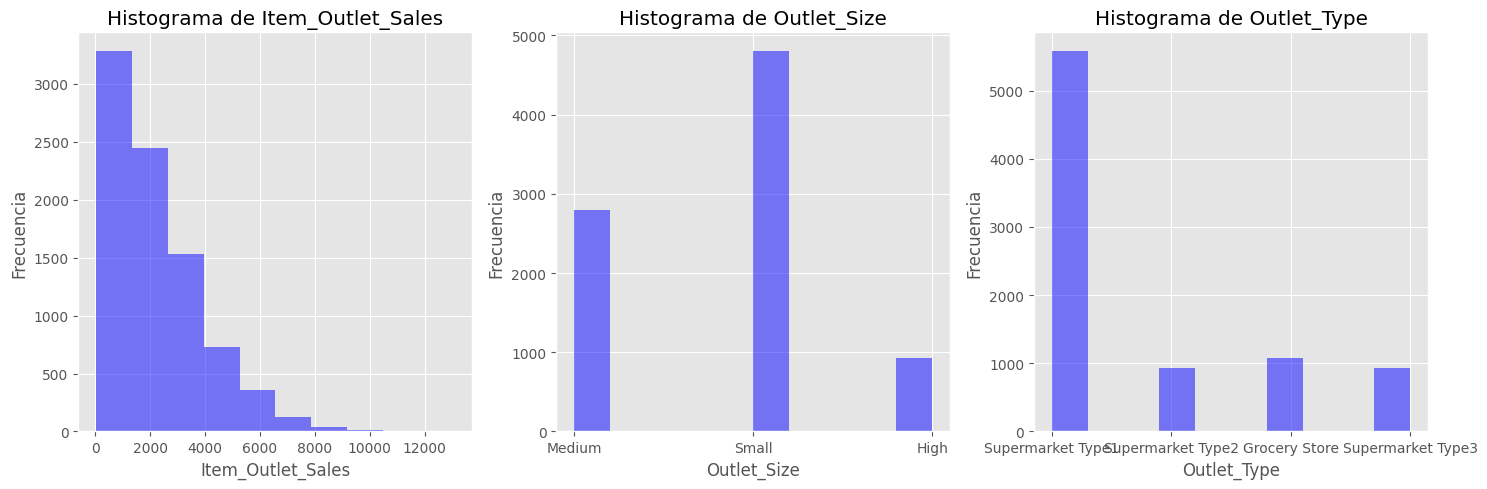

In [75]:

# Seleccionar características de interés

features = ['Item_Outlet_Sales', 'Outlet_Size', 'Outlet_Type']

# Crear un subplot para cada característica
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))

# Iterar a través de las características y trazar histogramas
for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=10, alpha=0.5, color='blue')
    axes[i].set_title(f'Histograma de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')

# Mostrar gráficos
plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

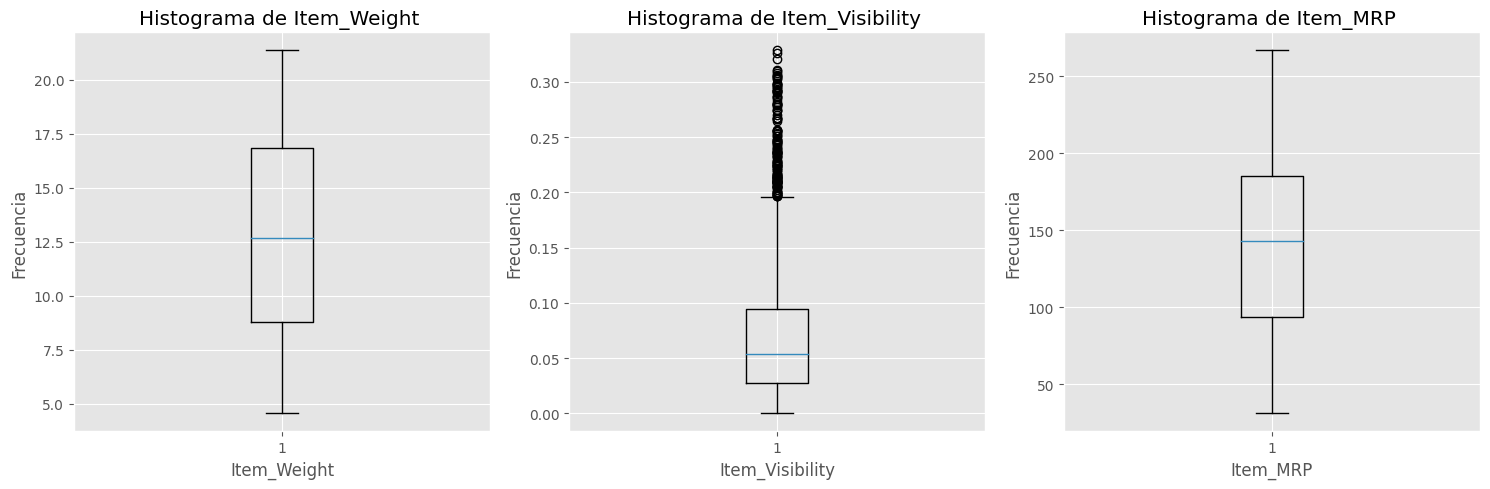

In [76]:
import matplotlib.pyplot as plt

# Seleccionar características de interés
features = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
# Agrupar por 'Item_Identifier' y calcular la media de cada grupo
grouped_df = df.groupby('Item_Identifier')[features].mean()

# Crear un subplot para cada característica
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))

# Iterar a través de las características y trazar histogramas
for i, feature in enumerate(features):
    axes[i].boxplot(df[feature])
    axes[i].set_title(f'Histograma de {feature} ')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')

# Mostrar gráficos
plt.tight_layout()
plt.show

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [78]:
#label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#identificar las columnas categoricas
categoricas = df.select_dtypes(include=['object']).columns.tolist()
#aplicar label encoder a cada columna categorica
df[categoricas] = df[categoricas].apply(lambda col: le.fit_transform(col))
df[categoricas].head(10)


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,156,0,4,9,1,0,1
1,8,1,14,3,1,2,2
2,662,0,10,9,1,0,1
3,1121,1,6,0,2,2,0
4,1297,0,9,1,0,2,1
5,758,1,0,3,1,2,2
6,696,1,13,1,0,2,1
7,738,0,13,5,1,2,3
8,440,1,5,7,2,1,1
9,990,1,5,2,2,1,1


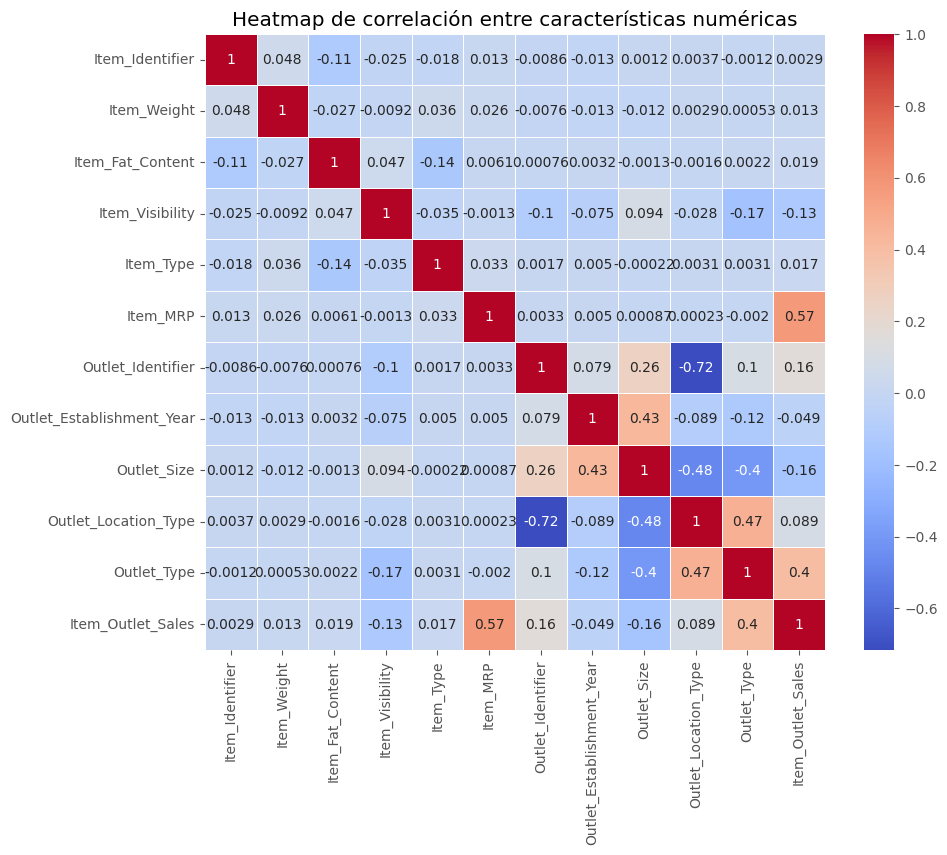

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calcular la matriz de correlación entre las columnas numéricas
correlation_matrix = df.corr()

# Crear un heatmap usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Establecer el título y mostrar el gráfico
plt.title("Heatmap de correlación entre características numéricas")
plt.show()


Proyecto 1 - Parte 4 (base)
Continuaremos trabajando en el proyecto de predicción de ventas. El objetivo de esto es ayudar al minorista a comprender las propiedades de los productos y los puntos de venta que desempeñan un papel crucial en el aumento de las ventas.
Para la cuarta parte, la tarea es crear numerosas visualizaciones de datos para ayudar a las partes interesadas a comprender mejor las tendencias de los datos. No duden en ser creativos esta semana. Esta es su oportunidad para distinguir sus proyectos de otros con visualizaciones y análisis.

• Aprovechen sus limpiezas, exploraciones y análisis anteriores.

• Creen un mínimo de dos visualizaciones de datos para ayudar a otros comprender las tendencias en los datos (análisis de datos explicativos).

• Puesto que estos gráficos son para la elaboración de informes, asegúrense de que tengan un buen aspecto incluyendo títulos, leyendas, etc.



In [80]:
outlet_sales = df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].mean().sort_values()

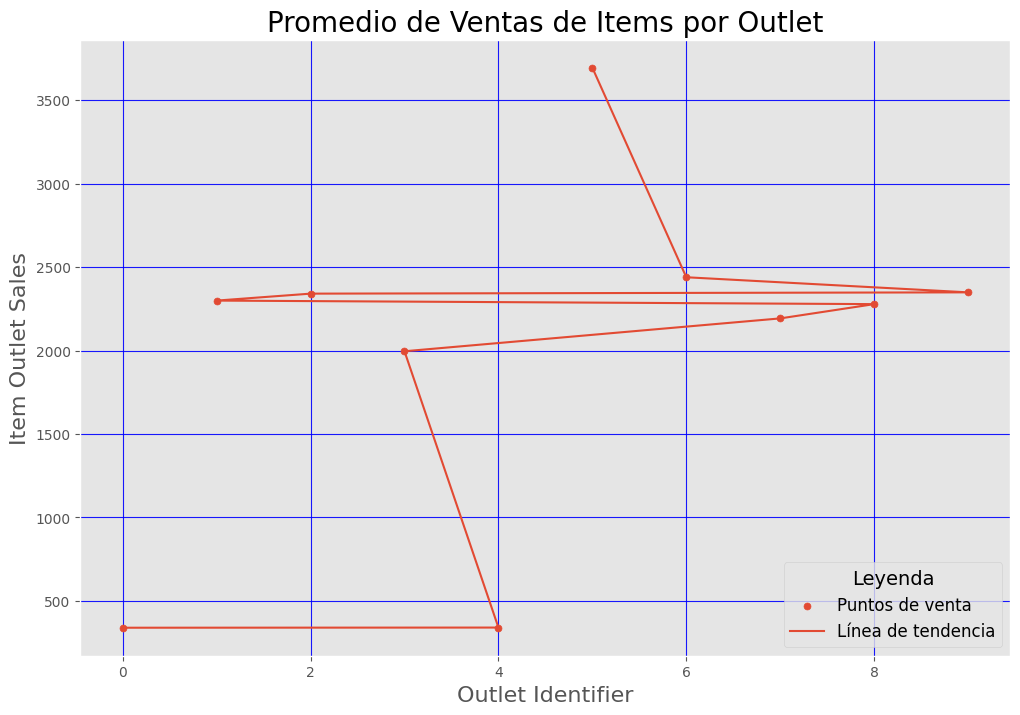

In [81]:

plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Dibujar los puntos con plt.scatter()

outlet_identifiers = outlet_sales.index
sales_means = outlet_sales.values

plt.scatter(outlet_identifiers, sales_means, marker='.', s=100, label='Puntos de venta')
plt.plot(outlet_identifiers, sales_means, linestyle='-', label='Línea de tendencia')

plt.xlabel('Outlet Identifier', fontsize=16)
plt.ylabel('Item Outlet Sales', fontsize=16)
plt.title('Promedio de Ventas de Items por Outlet', fontsize=20)
plt.grid(c='b',
         alpha=.9,
         linestyle='-')

plt.legend(loc='lower right', title="Leyenda",fontsize=12, title_fontsize=14)
plt.show()

 En el gráfico, se muestra el promedio de ventas de artículos para cada Outlet, y se puede observar una tendencia general en el rango de 2000 a 2500 en las ventas promedio. Además, la dispersión de las ventas promedio entre los diferentes Outlets varía desde un mínimo de aproximadamente 300 hasta un máximo de alrededor de 3700.

Este gráfico nos permite identificar cómo se comparan las ventas promedio entre los diferentes Outlets y también nos da una idea de la variabilidad en las ventas promedio en todo el conjunto de datos. A partir de esta información, podríamos investigar más a fondo las características de los Outlets con ventas más altas o más bajas y buscar factores que puedan estar influyendo en su desempeño.

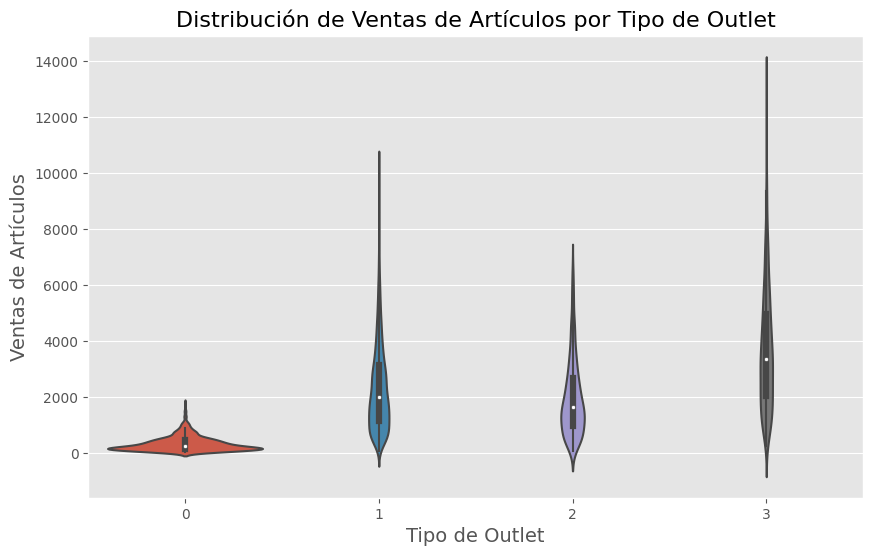

In [82]:
# Establecer el estilo del gráfico
plt.style.use('ggplot')

# Crear un gráfico de violín
plt.figure(figsize=(10, 6))
sns.violinplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df)

# Etiquetas y título del gráfico
plt.xlabel('Tipo de Outlet', fontsize=14)
plt.ylabel('Ventas de Artículos', fontsize=14)
plt.title('Distribución de Ventas de Artículos por Tipo de Outlet', fontsize=16)

# Mostrar el gráfico
plt.show()

 En el gráfico de violín que se creó, podemos observar que la mayor cantidad de ventas se concentra en los rangos entre 0 y 4000. Las tiendas "Grocery Store" tienen una distribución de ventas más pequeña, principalmente entre 0 y 2000, lo que sugiere que las ventas en estas tiendas son generalmente más bajas en comparación con otros tipos de tiendas.

Por otro lado, las tiendas "Supermarket Type 3" tienen una distribución de ventas más amplia, que abarca desde 0 hasta aproximadamente 14000. Esto indica que estas tiendas tienen una mayor variedad en el rango de ventas de artículos, incluyendo ventas más altas en comparación con los otros tipos de tiendas.

In [83]:

set_config(display='diagram')


y=df['Item_Outlet_Sales']
X=df.drop(columns='Item_Outlet_Sales')


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear los transformadores usando make_pipeline
num_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

# Crear el preprocessor usando make_column_transformer y make_column_selector
preprocessor = make_column_transformer(
    (num_transformer, make_column_selector(dtype_include=np.number)),
    (cat_transformer, make_column_selector(dtype_include='object'))
)

# Crear y ajustar el pipeline usando make_pipeline en los datos de entrenamiento
pipeline = make_pipeline(preprocessor)
pipeline.fit(X_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A39E76440>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A3869D540>)]))])

In [85]:
X_train_processed = pipeline.transform(X_train)
X_test_processed= pipeline.transform(X_test)

In [86]:
#regresion lineal
lr = LinearRegression()
lr.fit(X_train_processed, y_train)
y_pred = lr.predict(X_test_processed)


In [87]:
#evaluar el modelo con Raíz del Error Cuadrático Medio (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

1142.0523906653755


Las predicciones del modelo, en promedio, se desvían en 1142.05 unidades de las ventas reales.

In [88]:
#evaluar modelo con R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)

0.5201258177769238


El modelo explica el 52.01% de la variabilidad en las ventas. Aunque no es un valor extremadamente alto, es una indicación de que las variables independientes en el modelo tienen una relación significativa con las ventas. Sin embargo, aún queda un 47.99% de variabilidad que el modelo no puede explicar.